In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

Le but de ce TP est d’implementer un coût softmax, pour pouvoir appliquer la régression logistique à des problèmes de classification multiclasse. Dans ce contexte, la modélisation de la probabilité d’appartenance à une classe est donnée par :

$p(λ_k|x) = exp(x^t>w_k) / ∑^C_{j=1} exp(x^t>w_j )$

où x ∈ $R^{(d+1)}$ (vecteur augmenté), C est le nombre de classes et $w_k$ ∈ $R^{(d+1)}$. On appelle cette fonction, la fonction softmax.

En considérant que $y{i,j} = p(λ_j |x_i)$ est la ”vraie” probabilité d’appartenance à la classe $λ_j$ pour l’instance $x_i$, la fonction de coût s’écrit :

$L(y_i, ŷ_i) = −∑^C_{j=1}y_{i,j}log(ŷ{i,j} )$

où $ŷ{i,j}$ est modélisé par la fonction softmax ci-dessus.

Vous allez implémenter dans ce TP, un modèle de régression softmax régularisé appris tel que :

$min_W 1/n ∑^n_{i=1}L(yi, ŷi) + λ/2 ∑^C_{k=1}‖wk‖^2$

où W est une matrice (d + 1) × C contenant l’ensemble des $w_k$, ∀k = 1..C

1. Commencez par charger les données du dataset digits de Scikit-learn :

In [2]:
n_class = 10
X, y = load_digits(n_class=n_class , return_X_y=True)
n, d = X.shape

In [3]:
print(np.shape(X))

(1797, 64)


Donnez en quelques lignes une description de ces données et de la tâche sous-jacente. Précisez à quoi correspondent les caractéristiques

Os dados representam uma matriz 8x8 com a imagem de de um digito numerico de 0 a 9. Os valores de X variam de 0 a 1 representando a escala de cinza do digito, sendo zero um espaço vazio e 1 um pixel onde ha um traço bem definido.

2. Implémentez les fonctions permettant :
- de générer les encodages one-hot d’un ensemble de données à partir de leurs étiquettes.
- d’évaluer une fonction softmax étant donné un z = x>w
- d’estimer les ˆyi,j = p(λj |xi), ∀j = 1..C, ∀xi ∈ X et étant donné W.

In [4]:
def onehot_encoding(y, n_class):
    n = y.shape[0]
    y_one = np.zeros((n, n_class))
    for i in range(n):
        y_one[i, y[i]] = 1
    return y_one

def softmax(z):
    z -= np.max(z) # computational trick for numerical stability
        # sm = np.exp(z)/np.sum(np.exp(z))
        # return sm
    exp_z = np.exp(z)
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)
   

def get_prob_pred(X, W):
    z =  np.dot(X,W)
    probs = softmax(z)
    preds = np.argmax(probs)
    return probs, preds

3. Calculez analytiquement l’expression du gradient de la fonction de coût par rapport à W.

4. Implémentez maintenant une fonction qui calcule la fonction de coût et le gradient.

In [5]:
def get_loss_grad(W, X, y, lam , n_class):
    n = X.shape[0]
    y_mat = onehot_encoding(y, n_class) # convert the integer class coding into a one-hot representation
    scores = X @ W # compute raw class scores given our input and current weights
    prob = softmax(scores) # perform a softmax on these scores to get their probabilities
    loss = (-1 / n) * np.sum(y_mat * np.log(prob)) + (lam/2)*np.sum(W*W) 
    grad = (-1 / n) * np.dot(X.T,(y_mat - prob)) + lam*W 
    return loss , grad

5. Implémentez une descente de gradient avec backtracking pour optimiser les paramètres W.

In [6]:
def logreg_descent(X, y, max_iter=1000):
    W = np.zeros([X.shape[1],len(np.unique(y))])
    lam = 1
    tol = 1e-4
    alpha = 0.5
    beta = 0.9
    losses = []
    for i in range(0,max_iter):
        loss,grad = get_loss_grad(W,X,y,lam,n_class)
        losses.append(loss)

        # **Convergence seuil**
        if i > 0 and abs(losses[i] - losses[i-1]) < tol:
            print(f"Convergence at {i}th step")
            return W, losses[:i+1] 
        
        # **Backtracking**
        step = 1  
        while True:
            W_new = W - step * grad  
            new_loss, _ = get_loss_grad(W_new, X, y, lam, len(np.unique(y)))

            if new_loss <= loss - alpha * step * np.sum(grad ** 2):
                break  # If condition satisfied, stop updanting the step

            step *= beta # decreases step

        W = W_new

    return W, losses

In [7]:
X_plus = np.concatenate((X, np.ones((n, 1))), axis=1)
W, losses = logreg_descent(X_plus, y, max_iter=5000)

Convergence at 40th step


6. Visualisez l’évolution de la fonction de coût en fonction du nombre d’itérations et analysez ce que vous observez.

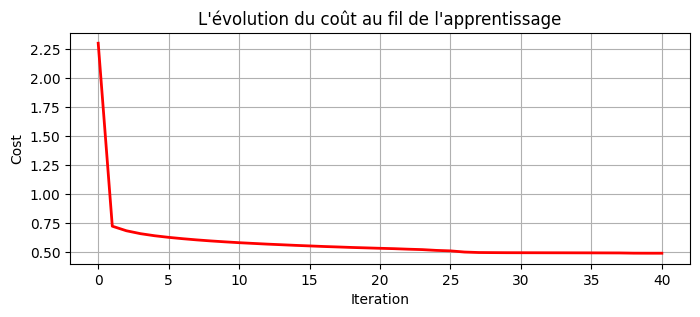

In [8]:
plt.figure(figsize=(8, 3))
plt.plot(range(len(losses)), losses, color="red", linewidth=2)
plt.title("L'évolution du coût au fil de l'apprentissage")
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.grid(True)
plt.show()

<div style="background-color:#f0f8ff; color:#333333; padding:10px; border-radius:8px; font-family:Arial, sans-serif; line-height:1.6;">
  <p>
    We can see that the loss decreases rapidly in the first iteration thanks to backtracking, which means that the first step we took positioned us close to the minimum loss. Then, the loss decrease converges until the execution is stopped around the 40th iteration. Therefore, the algorithm seems to have succeeded in defining good parameters for classification.
  </p>
</div>

7. Proposez un protocole d’évaluation de votre méthode et commentez les résultats obtenus.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_plus, y, test_size=0.2, random_state=42, stratify=y)

# **train**
W, losses = logreg_descent(X_train, y_train, max_iter=5000)

# **predict**
scores = X_test @ W
prob = softmax(scores)
y_pred = np.argmax(prob, axis=1)

# **Evaluate**
accuracy = accuracy_score(y_test, y_pred)
print(f"Précision du modèle : {100*accuracy:.2f}%")


Convergence at 38th step
Précision du modèle : 95.28%


<div style="background-color:#f0f8ff; color:#333333; padding:10px; border-radius:8px; font-family:Arial, sans-serif; line-height:1.6;">
  <p>
    The dataset was divided into training and testing so that we could train a classification model. The trained model was used to predict test labels and then we measured the accuracy using scikit-learn. As we can see, the model achieved a high accuracy (95.28%), which is quite satisfactory.
  </p>
</div>

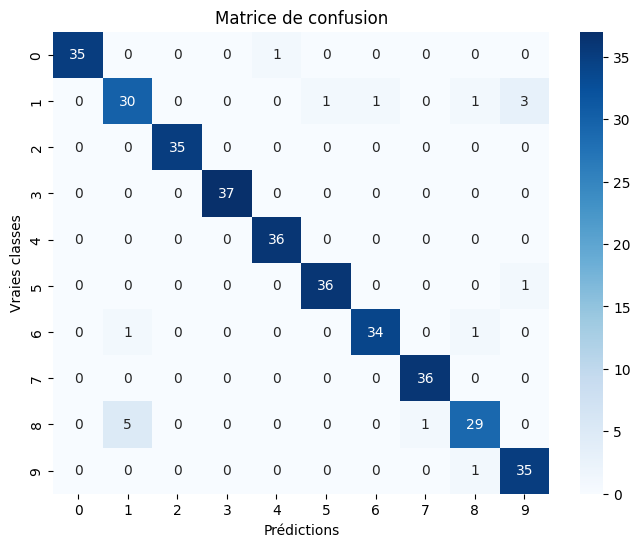

In [10]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Prédictions")
plt.ylabel("Vraies classes")
plt.title("Matrice de confusion")
plt.show()

<div style="background-color:#f0f8ff; color:#333333; padding:10px; border-radius:8px; font-family:Arial, sans-serif; line-height:1.6;">
  <p>
    Looking at the confusion matrix given by this model, we see that the biggest offenders are digits "8" being classified as "1" and digits "1" being classified as "9".
  </p>
</div>

Total de erros: 17


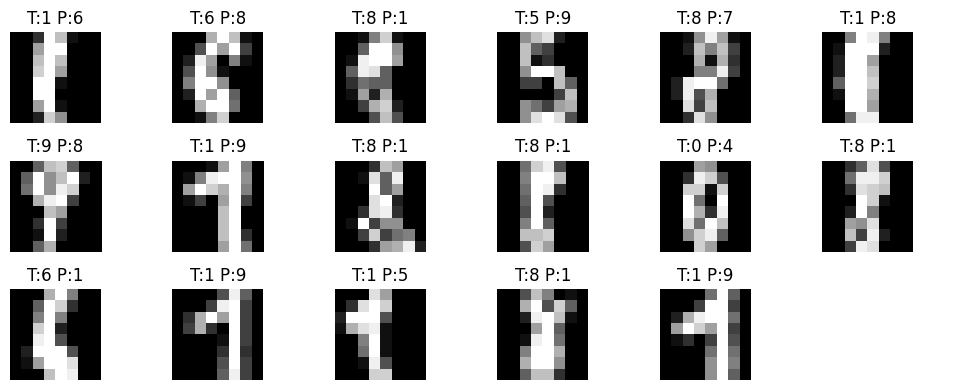

In [ ]:
# **Identify errors**
errors = np.where(y_pred != y_test)[0]
print(f"Total de erros: {len(errors)}")

# **Visualize**
num_errors = len(errors)
rows, cols = 3, 6 # grid size
fig, axes = plt.subplots(rows, cols, figsize=(10, 4))

for i, ax in enumerate(axes.flat):
    if i < num_errors:
        idx = errors[i]
        ax.imshow(X_test[idx, :-1].reshape(8, 8), cmap='gray')
        ax.set_title(f"T:{y_test[idx]} P:{y_pred[idx]}")
        ax.axis('off')
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()

<div style="background-color:#f0f8ff; color:#333333; padding:10px; border-radius:8px; font-family:Arial, sans-serif; line-height:1.6;">
  <p>
    By viewing the incorrect predictions, we can see that for most of the digits there is no room for doubt in the human classification of these digits, that is, there are nuances in the data that the model was not able to identify.
  </p>
</div>